##### This notebook explores training logistic regression models to classify author gender and topic of master theses from Chalmers and GU. The models are trained on a downsampled dataset that includes theses from departments within the four topics Humanities, Architecture, Economy and Natural Science, with an equal number of male and female authors represented in each included department. #####

##### The features used are frequencies of function words, as approximated by the most frequent 200 words in the corpus, frequencies of pronouns, and frequencies of unigrams, bigrams and trigrams of part-of-speech tags. #####



##### The accuracies on training and test data, using the full set of features are: #####

|  | Topic | Gender |
| --- | --- | --- |
| Swedish, train | 1.0 | 0.94
| Swedish, test   | 0.95 | 0.72 |
| English, train | 1.0 | 0.87
| English, test | 0.91 | 0.66

##### The higher accuracy scores for the Swedish data are possibly due to the more detailed pos-tags available for Swedish. #####

##### The baseline of simply guessing the gender would achieve an accuracy of around 50%. #####
##### The baseline for topic prediction (always predicting the majority class) is around 43% for English and 53% for Swedish. The Swedish model is worse at predicting natural science, which has only 59 samples in the training data. (See the code below for more detailed accuracy, precision and recall scores).   #####


##### We are looking for stylistic differences in the writing of male and female authors, and hence do not want gender predictions to be influenced by topic. Therefore, we explore ways to drop the features that are strong predictors of topic, while keeping those that have high correlation with gender. #####


##### The strongest predictors for the different topics are: #####

|  | Swedish | English|
| --- | :- | :- |
| Humanities | exempel,  (NN.UTR.SIN.IND.NOM, PAD), jag, här, om, hans |  whether, her, use, him, his
| Architecture   | mitt, NN.-.-.-.SMS,NN.NEU.PLU.IND.NOM, KN, NN.UTR.PLU.IND.NOM,JJ.KOM.UTR+NEU.SIN+PLU.IND+DEF.NOM  | (CC, NP, NP), water, construction, project, people |
| Economy | studien, resultat, mål, företag, respondenterna, då | companies, market, our, whether, business, management
| Natural Science | (PP, NN.UTR.SIN.IND.NOM, RG.NOM), (VB.PRS.AKT, VB.SUP.AKT, PP), VB.PRT.SFO, NN.AN     |(NNS, ',', IN), production ,(NN, NP, CD)  , power, temperature, enough

##### The strongest predictors for gender are: #####

|  | Swedish | English|
| --- | :- | :- |
| Male |  AB.POS, (KN, NN.UTR.PLU.IND.NOM), vilken, (DT.NEU.SIN.IND, NN.NEU.SIN.IND.NOM), HP.-.-.- , (None, PN.UTR.PLU.DEF.SUB, VB.PRS.AKT) | most, (NP, POS, NN), WRB   , RB, is, (SENT, None, DT), what, (NNS, IN, DT), him
| Female  | både, (MAD, None, PN.UTR.PLU.DEF.SUB), inte, KN, och, då, (JJ, NN, SYM), (NN, None, NN)   | RBS, VB, (TO, VV), (NNS, CC), not, (RB, RB, IN),(None, LS, SENT)          |

##### We iteratively remove features from the input where the coefficient for some topic is higher than a given threshold. In a second experiment, we instead iteratively remove the features where smallest difference between the coefficients of the topics is greater than the absolute value of the corresponding coefficient in the model that predicts gender. When removing features in this way, the accuracy drops considerably faster when predicting topic, compared to gender, however, the accuracy still stays above the baseline. #####

##### The PCA plots of the reduced features of the inputs still show a pattern where theses of the same topic are close together. See code and output below for further details #####

In [1]:
from preprocess_inputs import scale_frequencies, gender_to_int, topic_to_int

import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score

from scipy.sparse import csr_matrix

import seaborn as sns
import matplotlib.pyplot as plt



#### Load the precomputed part-of-speech and function word frequencies ####

In [2]:
freqs = pd.read_csv("data/frequencies_swe.csv")
df    = pd.read_csv("data/df_swedish_downsampled.csv")

freqs_eng = pd.read_csv("./data/frequencies_eng.csv")
df_eng    = pd.read_csv("data/df_english_downsampled.csv")

freqs.drop_duplicates(subset=['id'],inplace=True)
freqs_eng.drop_duplicates(subset=['id'],inplace=True)

ids     = freqs['id'].values
ids_eng = freqs_eng['id'].values

# Drop junk columns
freqs_eng = freqs_eng.drop(['Unnamed: 0' , 'Unnamed: 1'], axis=1)
freqs = freqs.drop(['Unnamed: 0'], axis=1)


#### Get the gender/topic labels of the theses in the same order as the in the frequency table ####


In [3]:

labels_gender = [gender_to_int(df[df['id'] == ident]['gender_composition'].values[0]) for ident in ids]
labels_topic  = [topic_to_int(df[df['id'] == ident]['department'].values[0]) for ident in ids]

labels_gender_eng = [gender_to_int(df_eng[df_eng['id'] == ident]['gender_composition'].values[0]) for ident in ids_eng]
labels_topic_eng  = [topic_to_int(df_eng[df_eng['id'] == ident]['department'].values[0]) for ident in ids_eng]

#### Remove identifier from model input ####

In [4]:
freqs     = freqs.drop(['id'],axis=1)
freqs_eng = freqs_eng.drop(['id'],axis=1)

#### Keep the feature labels (for listing important features later) ####

In [5]:
freqs_features     = freqs.columns
freqs_features_eng = freqs_eng.columns

#### Subtract mean, and scale to unit variance #### 

In [6]:
freqs_eng = freqs_eng.to_numpy()
freqs     = freqs.to_numpy()

freqs_eng = scale_frequencies(freqs_eng)
freqs     = scale_frequencies(freqs)

#### Split into train and test sets ####

In [7]:

indices     = [i for i in (range(len(freqs)))]
indices_eng = [i for i in (range(len(freqs_eng)))]

def zip_(xs,ys) :
    return [(xs[i],ys[i]) for i in range(len(xs))]

# Get the indices of training and test data -
# (these are used also for the reduced feature sets).
X_train_indices, X_test_indices, y_train, y_test = train_test_split(indices, zip_(labels_topic,labels_gender), test_size=0.25, random_state=42)
X_train_indices_eng, X_test_indices_eng, y_train_eng, y_test_eng = train_test_split(indices_eng, zip_(labels_topic_eng,labels_gender_eng), test_size=0.25, random_state=42)


In [8]:
X_train     = [freqs[i] for i in X_train_indices]
X_train_eng = [freqs_eng[i] for i in X_train_indices_eng]

X_test     = [freqs[i] for i in X_test_indices]
X_test_eng = [freqs_eng[i] for i in X_test_indices_eng]

#### Get the gender and topic labels for train and test sets ####

In [9]:

labels_gen_train   = [gen for (top,gen) in y_train]
labels_gen_test    = [gen for (top,gen) in y_test]

labels_topic_train = [top for (top,gen) in y_train]
labels_topic_test  = [top for (top,gen) in y_test]

labels_gen_train_eng = [gen for (top,gen) in y_train_eng]
labels_gen_test_eng  = [gen for (top,gen) in y_test_eng]

labels_topic_train_eng = [top for (top,gen) in y_train_eng]
labels_topic_test_eng  = [top for (top,gen) in y_test_eng]

In [10]:
# Create logistic regression model
def logreg() : 
    return LogisticRegression(multi_class='multinomial',solver='saga',penalty = 'l1',max_iter=1000)


#### Convert to sparse matrices to speed up training ####

In [11]:

X_train_sparse = csr_matrix(X_train)
X_test_sparse  = csr_matrix(X_test)

X_train_sparse_eng = csr_matrix(X_train_eng)
X_test_sparse_eng  = csr_matrix(X_test_eng)

#### Initialize logistic regression model and fit on full inputs and gender labels ####


In [12]:

log_model_gender     = logreg()
log_model_gender.fit(X_train_sparse,labels_gen_train)

log_model_gender_eng     = logreg()
log_model_gender_eng.fit(X_train_sparse_eng,labels_gen_train_eng)


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(max_iter=1000, multi_class='multinomial', penalty='l1',
                   solver='saga')

In [13]:
coefs_gender = log_model_gender.coef_
coefs_gender_eng = log_model_gender_eng.coef_

In [14]:

# Accuracies for logistic regression model trained on gender
print("Predicting gender of training data (Swedish):")
print(classification_report(labels_gen_train,log_model_gender.predict(X_train_sparse),labels=[0,1],target_names=['female','male']))

print("Predicting gender of test data (Swedish):")
print(classification_report(labels_gen_test,log_model_gender.predict(X_test_sparse),labels=[0,1],target_names=['female','male']))



Predicting gender of training data (Swedish):
              precision    recall  f1-score   support

      female       0.93      0.94      0.94      1185
        male       0.94      0.93      0.94      1224

    accuracy                           0.94      2409
   macro avg       0.94      0.94      0.94      2409
weighted avg       0.94      0.94      0.94      2409

Predicting gender of test data (Swedish):
              precision    recall  f1-score   support

      female       0.73      0.73      0.73       421
        male       0.70      0.70      0.70       382

    accuracy                           0.72       803
   macro avg       0.72      0.72      0.72       803
weighted avg       0.72      0.72      0.72       803



In [15]:
print("Predicting gender of training data (English):")
print(classification_report(labels_gen_train_eng,log_model_gender_eng.predict(X_train_sparse_eng),labels=[0,1],target_names=['female','male']))

print("Predicting gender of test data (English):")
print(classification_report(labels_gen_test_eng,log_model_gender_eng.predict(X_test_sparse_eng),labels=[0,1],target_names=['female','male']))



Predicting gender of training data (English):
              precision    recall  f1-score   support

      female       0.87      0.87      0.87      1480
        male       0.87      0.87      0.87      1478

    accuracy                           0.87      2958
   macro avg       0.87      0.87      0.87      2958
weighted avg       0.87      0.87      0.87      2958

Predicting gender of test data (English):
              precision    recall  f1-score   support

      female       0.66      0.65      0.66       492
        male       0.66      0.67      0.66       494

    accuracy                           0.66       986
   macro avg       0.66      0.66      0.66       986
weighted avg       0.66      0.66      0.66       986



In [16]:
log_model_topic = logreg()
log_model_topic.fit(X_train_sparse,labels_topic_train)


log_model_topic_eng     = logreg()
log_model_topic_eng.fit(X_train_sparse_eng,labels_topic_train_eng)


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


LogisticRegression(max_iter=1000, multi_class='multinomial', penalty='l1',
                   solver='saga')

In [17]:
# Accuracies for logistic regression model trained on topic

print("Predicting topic of training data (Swedish):")
print(classification_report(labels_topic_train,log_model_topic.predict(X_train_sparse),labels=[0,1,2,3],target_names=['humaniora','arkitektur','ekonomi','naturvetenskap']))

print("Predicting topic of test data (Swedish):")
print(classification_report(labels_topic_test,log_model_topic.predict(X_test_sparse),labels=[0,1,2,3],target_names=['humaniora','arkitektur','ekonomi','naturvetenskap']))



Predicting topic of training data (Swedish):
                precision    recall  f1-score   support

     humaniora       1.00      1.00      1.00       543
    arkitektur       1.00      1.00      1.00       602
       ekonomi       1.00      1.00      1.00      1205
naturvetenskap       1.00      1.00      1.00        59

      accuracy                           1.00      2409
     macro avg       1.00      1.00      1.00      2409
  weighted avg       1.00      1.00      1.00      2409

Predicting topic of test data (Swedish):
                precision    recall  f1-score   support

     humaniora       0.90      0.99      0.94       149
    arkitektur       0.92      0.93      0.93       214
       ekonomi       0.99      0.95      0.97       423
naturvetenskap       0.80      0.71      0.75        17

      accuracy                           0.95       803
     macro avg       0.90      0.89      0.90       803
  weighted avg       0.95      0.95      0.95       803



In [18]:
# Accuracies for logistic regression model trained on topic

print("Predicting topic of training data (English):")
print(classification_report(labels_topic_train_eng,log_model_topic_eng.predict(X_train_sparse_eng),labels=[0,1,2,3],target_names=['humaniora','arkitektur','ekonomi','naturvetenskap']))

print("Predicting topic of test data (English):")
print(classification_report(labels_topic_test_eng,log_model_topic_eng.predict(X_test_sparse_eng),labels=[0,1,2,3],target_names=['humaniora','arkitektur','ekonomi','naturvetenskap']))



Predicting topic of training data (English):
                precision    recall  f1-score   support

     humaniora       1.00      1.00      1.00       262
    arkitektur       1.00      1.00      1.00      1269
       ekonomi       1.00      1.00      1.00       466
naturvetenskap       1.00      1.00      1.00       961

      accuracy                           1.00      2958
     macro avg       1.00      1.00      1.00      2958
  weighted avg       1.00      1.00      1.00      2958

Predicting topic of test data (English):
                precision    recall  f1-score   support

     humaniora       0.90      0.95      0.92        92
    arkitektur       0.94      0.89      0.92       425
       ekonomi       0.89      0.97      0.93       156
naturvetenskap       0.89      0.91      0.90       313

      accuracy                           0.91       986
     macro avg       0.91      0.93      0.92       986
  weighted avg       0.92      0.91      0.91       986



#### Get the coefficients from the topic classification models #### 

In [19]:

coefs_topic      = log_model_topic.coef_
coefs_humaniora  = coefs_topic[0]
coefs_arkitektur = coefs_topic[1]
coefs_ekonomi    = coefs_topic[2]
coefs_natur      = coefs_topic[3]


coefs_topic_eng      = log_model_topic_eng.coef_
coefs_humaniora_eng  = coefs_topic_eng[0]
coefs_arkitektur_eng = coefs_topic_eng[1]
coefs_ekonomi_eng    = coefs_topic_eng[2]
coefs_natur_eng      = coefs_topic_eng[3]

In [20]:
def pad(str,n) :
    return (str + ''.join([' ' for i in range(n - len(str))]))

def list_important_features(features,coefs,threshold) :
    for feat,val in sorted([ (features[i],val) for i,val in enumerate(coefs) if val > threshold ], key=lambda x : x[1],reverse=True) :
        print(pad(feat,30) + str(val))
    

#### List the important features for predicting humaniora (English) #### 

In [21]:
list_important_features(freqs_features_eng,coefs_humaniora_eng,0.1)

whether                       0.298457328817717
her                           0.2895576592703692
``                            0.24361705265742575
use                           0.2364589189672592
him                           0.23166909385040707
his                           0.2200312245311526
VVZ                           0.20580972021746635
construction                  0.19618139489601227
('NP', ':', 'NP')             0.19083866052583245
('POS', 'NN', 'NN')           0.1789819966188463
('CD', ')', ',')              0.17670568731927508
('PP$', 'JJ', 'NN')           0.15657168318391326
she                           0.1555918708361374
herself                       0.15096053024295739
('VVZ', 'DT', 'JJ')           0.14480926686876502
IN/that                       0.14344679185531953
used                          0.142554634439998
('SENT', None, 'IN')          0.1409602619218285
only                          0.14032247545448273
('DT', 'NN', 'IN/that')       0.13821272604227108
('NP', 'PO

#### Lists the features that are important for humaniora (Swedish) ####

In [22]:
list_important_features(freqs_features,coefs_humaniora,0.15)

svenska                       0.31274823456055856
exempel                       0.2241104363630367
('NN.UTR.SIN.IND.NOM', 'PAD') 0.2224499458097047
jag                           0.21047997250414385
här                           0.20781395094673225
om                            0.20645050733608283
hans                          0.19790625874138906
('PAD', 'PM.NOM', 'RG.NOM')   0.19501336298006985
('PM.NOM', 'VB.PRS.AKT', 'PP')0.19413917143650072
forskning                     0.19059250162173952
('MID', 'RG.NOM', 'MAD')      0.18977669897625302
som                           0.18686459676466907
('PP', 'NN.UTR.SIN.DEF.NOM', 'PAD')0.1704316872606413
min                           0.16564459122927025
sig                           0.1621991477525417
NN.UTR.PLU.DEF.GEN            0.15167564177249016
NN.UTR.PLU.IND.GEN            0.1516004717633813


#### Lists the features that are important for arkitektur (English) ####

In [23]:

list_important_features(freqs_features_eng,coefs_arkitektur_eng,0.3)

('CC', 'NP', 'NP')            0.5843013916501291
construction                  0.5804243559477562
water                         0.5790420857457016
project                       0.538832577158143
people                        0.5288201334216491
environment                   0.4062402344436396
('SENT', None, 'CC')          0.37532758470564104
building                      0.3673200058118984
part                          0.3432190459710356
('DT', 'NN', 'WDT')           0.343159826252199
method                        0.32138133165939703
design                        0.3100262177343846
JJR                           0.30301800536465673
('NN', 'CD', ':')             0.3025548504863215


#### Lists the features that are important for arkitektur (Swedish) ####

In [24]:
list_important_features(freqs_features,coefs_arkitektur,0.15)

mitt                          0.3401592373246646
NN.-.-.-.SMS                  0.2769918765922161
('NN.NEU.PLU.IND.NOM', 'KN', 'NN.UTR.PLU.IND.NOM')0.25199650446160277
JJ.KOM.UTR+NEU.SIN+PLU.IND+DEF.NOM0.2460127374698885
ett                           0.2367804138149114
('RG.NOM', None, 'NN.UTR.SIN.IND.NOM')0.23598074428850507
('KN', 'NN.UTR.SIN.IND.NOM', 'MID')0.21965614424586796
blir                          0.2165374434534994
(None, 'JJ.POS.UTR.SIN.IND.NOM', 'NN.UTR.SIN.IND.NOM')0.21166617309009475
(None, 'NN.NEU.SIN.DEF.NOM', 'VB.PRS.AKT')0.20657151765185747
hela                          0.2053583261654872
('UO', 'UO', 'UO')            0.2002002102837917
JJ.POS.MAS.SIN.DEF.GEN        0.19299099929316618
('PAD', 'PM.NOM', 'MID')      0.1919927521792617
NN.UTR.-.-.SMS                0.18076074246703566
('PP', 'PM.NOM', 'MAD')       0.17999195895221687
JJ.POS.UTR.SIN.IND+DEF.NOM    0.17338700988877834
('VB.INF.AKT', 'DT.UTR.SIN.IND', 'JJ.POS.UTR.SIN.IND.NOM')0.17146296638876823
('PL', 

#### Lists the features that are important for ekonomi (English) ####

In [25]:
list_important_features(freqs_features_eng,coefs_ekonomi_eng,0.2)

companies                     0.6585688638580006
market                        0.4327643150430976
our                           0.378042635062367
whether                       0.3353754511779077
business                      0.31639888884380835
management                    0.26987909625496703
cost                          0.2595001737489872
control                       0.257936440981744
she                           0.2447561159626052
value                         0.23771273604489446
('NN', ',', 'WDT')            0.2303470519842006
further                       0.2228936108347526
company                       0.21953974668858
herself                       0.2134509721007191
NPS                           0.21122153178211042
thesis                        0.20466906934834905


#### Lists the features that are important for ekonomi (Swedish) ####

In [26]:
list_important_features(freqs_features,coefs_ekonomi,0.2)

resultat                      0.3483858484195034
studien                       0.3461225655626322
mål                           0.33266447119866854
företag                       0.3263004194067751
respondenterna                0.32613748672356846
då                            0.29600645957515576
KN.AN                         0.2876027710096545
('MID', 'PM.NOM', 'MAD')      0.2767694009179205
('RG.NOM', 'PAD', 'VB.PRS.AKT')0.25933948021148084
(None, 'PAD', 'PM.NOM')       0.2558184710348785
sådan                         0.25318872822267224
innebär                       0.24468151484004794
inom                          0.24109305051595903
('PM.NOM', 'KN.AN', 'PM.NOM') 0.23966793009919124
vill                          0.2336810477010807
JJ.SUV.UTR+NEU.SIN+PLU.DEF.NOM0.23204482607755803
annan                         0.2307914463845003
företaget                     0.23061097311510592
VB.SUP.AKT                    0.23048339797049644
syfte                         0.23035688893893494
PC.PRF.

#### Lists the features that are important for naturvetenskap (English): ####

In [27]:

list_important_features(freqs_features_eng,coefs_natur_eng,0.25)

environmental                 0.48581338495078785
current                       0.3854337580082632
('NNS', ',', 'IN')            0.34348495162653775
('NN', 'NP', 'CD')            0.3391588645600882
production                    0.33914095931109456
power                         0.33434205327523253
temperature                   0.3092796318458366
enough                        0.28293101104502866
('VVN', 'IN', 'VVG')          0.27784184106622
('VVN', 'SENT', None)         0.2737200402138226
technology                    0.2707625707985964
('SENT', None, 'NNS')         0.26118766734277443
energy                        0.2580659421400798
('NN', ',', 'DT')             0.25672978099145727
development                   0.25430716829677324


#### Lists the features that are important for naturvetenskap (Swedish): ####

In [28]:

list_important_features(freqs_features,coefs_natur,0.1)

('PP', 'NN.UTR.SIN.IND.NOM', 'RG.NOM')0.18225602564300322
('VB.PRS.AKT', 'VB.SUP.AKT', 'PP')0.1732936495777191
VB.PRT.SFO                    0.15451798212703804
NN.AN                         0.14858080253880532
('PAD', 'RG.NOM', 'PAD')      0.14048315591293234
('VB.PRS.AKT', 'NN.UTR.SIN.DEF.NOM', 'PP')0.1299383343032076
('NN.UTR.SIN.DEF.NOM', 'VB.PRS.SFO', 'PP')0.12782345034104195
to                            0.1253627893002946
('RG.NOM', 'PAD', 'PM.NOM')   0.11310139957256791
(None, 'PP', 'NN.UTR.SIN.IND.NOM')0.11271296914286748
('PP', 'NN.UTR.SIN.DEF.NOM', 'VB.PRS.AKT')0.1075613594703674


#### Lists the features that are important for gender male (Swedish): ####

In [29]:
list_important_features(freqs_features,coefs_gender[0],0.3)

AB.POS                        0.4369157855036862
('KN', 'NN.UTR.PLU.IND.NOM')  0.39067980971151584
vilken                        0.367998687321585
('DT.NEU.SIN.IND', 'NN.NEU.SIN.IND.NOM')0.3546967425432193
HP.-.-.-                      0.34788322813177386
(None, 'PN.UTR.PLU.DEF.SUB', 'VB.PRS.AKT')0.338836290467637
('VB.PRS.AKT', 'AB')          0.3362909750783229
den                           0.3088602504818223
of                            0.3088518506790375


#### Lists the features that are important for gender male (English): ####

In [30]:


list_important_features(freqs_features_eng,coefs_gender_eng[0],0.2)

most                          0.5119562185997543
('NP', 'POS', 'NN')           0.3915327269268305
WRB                           0.3349346912863393
RB                            0.30167834031928775
is                            0.28869210922451727
('SENT', None, 'DT')          0.2821843138330261
what                          0.27590269992621236
('NNS', 'IN', 'DT')           0.2624211264026503
him                           0.23884279307853878
('VV', 'DT', 'NNS')           0.21628826779895358
(',', 'NP', 'SENT')           0.2036978801286733
that                          0.20183634840301995


#### Lists the features that are important for gender female (Swedish): ####

In [31]:
def list_important_features_neg(features,coefs,threshold) :
    for feat,val in sorted([ (features[i],val) for i,val in enumerate(coefs) if val < threshold ], key=lambda x : x[1],reverse=False) :
        print(pad(feat,30) + str(val))
        
list_important_features_neg(freqs_features,coefs_gender[0],-0.3)

både                          -0.45813157493189094
('MAD', None, 'PN.UTR.PLU.DEF.SUB')-0.45286070838012216
inte                          -0.4175001247809299
KN                            -0.38103115084090183
och                           -0.3522439336509088
då                            -0.34793339077888763
('PL', 'PP')                  -0.34057616873627855
NN.NEU.SIN.DEF.NOM            -0.32072024245537484
samt                          -0.31260082197306444
('PP', 'NN.UTR.SIN.IND.NOM', 'MID')-0.30981974436576476
HD.UTR.SIN.IND                -0.3051110422738856


#### Lists the features that are important for gender female (English): ####

In [32]:
list_important_features_neg(freqs_features_eng,coefs_gender_eng[0],-0.2)

RBS                           -0.4259098145672708
VB                            -0.3741976822375634
('TO', 'VV')                  -0.3473284279799492
('NNS', 'CC')                 -0.28549994004761675
not                           -0.26042936537307887
('RB', 'RB', 'IN')            -0.2530944404433792
(None, 'LS', 'SENT')          -0.22285131751428572
('JJ', 'NN', 'SYM')           -0.206618782728249
('NN', None, 'NN')            -0.20276147611304662


#### Get the indices of the features with topic coefficient above the given threshold ####

In [33]:
def joinlists(xs) : 
    return [j for i in xs for j in i]


def get_important_indices(threshold,coefs) : 
 return sorted(joinlists([ [i for i,val in enumerate(coef) if val > threshold] for coef in coefs ]))
               

#### List all indices of features that are above the given threshold for some topic ####

In [34]:

thresholds =  [0.12,0.11,0.1,0.09,0.08,0.07,0.06,0.05,0.04,0.03,0.02,0.01]

important_indices_by_threshold     = [get_important_indices(threshold,[coefs_humaniora,coefs_arkitektur,coefs_ekonomi,coefs_natur]) for threshold in thresholds]
important_indices_by_threshold_eng = [get_important_indices(threshold,[coefs_humaniora_eng,coefs_arkitektur_eng,coefs_ekonomi_eng,coefs_natur_eng]) for threshold in thresholds]


#### For all inputs, remove the columns of the features that have high topic correlation ####

In [35]:
def new_inputs_by_threshold(freqs,important_indices) :
    return [[ [ inp[i] for i in range(len(inp)) if i not in important_indices[j]] for inp in freqs] for j in range(len(important_indices))]


#### Create a list for each threshold, where each list includes the features with topic importance lower than the corresponding threshold ####


In [36]:

new_inputs     = new_inputs_by_threshold(freqs,important_indices_by_threshold)

inputs_topic_reduced_train = [ [ inps[i] for i in X_train_indices] for inps in new_inputs]
inputs_topic_reduced_test  = [ [ inps[i] for i in X_test_indices] for inps in new_inputs]


#### Convert inputs to sparse matrices #### 

In [37]:
inputs_topic_reduced_train =  [X_train_sparse] + [csr_matrix(inp) for inp in inputs_topic_reduced_train ]

inputs_topic_reduced_test  = [X_test_sparse] + [csr_matrix(inp) for inp in inputs_topic_reduced_test ]


#### Same as above, for English inputs ####

In [38]:
new_inputs_eng = new_inputs_by_threshold(freqs_eng,important_indices_by_threshold_eng)

inputs_topic_reduced_train_eng = [ [ inps[i] for i in X_train_indices_eng] for inps in new_inputs_eng]
inputs_topic_reduced_test_eng  = [ [ inps[i] for i in X_test_indices_eng] for inps in new_inputs_eng]

inputs_topic_reduced_train_eng = [X_train_sparse_eng] + [csr_matrix(inp) for inp in inputs_topic_reduced_train_eng ]
inputs_topic_reduced_test_eng  = [X_test_sparse_eng] + [csr_matrix(inp) for inp in inputs_topic_reduced_test_eng ]


#### Fit a logistic regression model to classify topic on each list of inputs with the reduced features ####

In [ ]:
log_model_topic_reduced_topic = [logreg() for i in range(len(thresholds))]

for i in range(len(thresholds)) :
    log_model_topic_reduced_topic[i].fit(inputs_topic_reduced_train[i],labels_topic_train)

In [ ]:
log_model_topic_reduced_topic_eng = [logreg() for i in range(len(thresholds))]

for i in range(len(thresholds)) :
    log_model_topic_reduced_topic_eng[i].fit(inputs_topic_reduced_train_eng[i],labels_topic_train_eng)

#### Fit a logistic regression model to classify gender on the same inputs with reduced features ####

In [ ]:

log_model_topic_reduced = [logreg() for i in range(len(thresholds))]

for i in range(len(thresholds)) :
    log_model_topic_reduced[i].fit(inputs_topic_reduced_train[i],labels_gen_train)

In [ ]:
log_model_topic_reduced_eng = [logreg() for i in range(len(thresholds))]

for i in range(len(thresholds)) :
    log_model_topic_reduced_eng[i].fit(inputs_topic_reduced_train_eng[i],labels_gen_train_eng)

#### Plot the accuracies on the test data for the gender model and the topic model ####

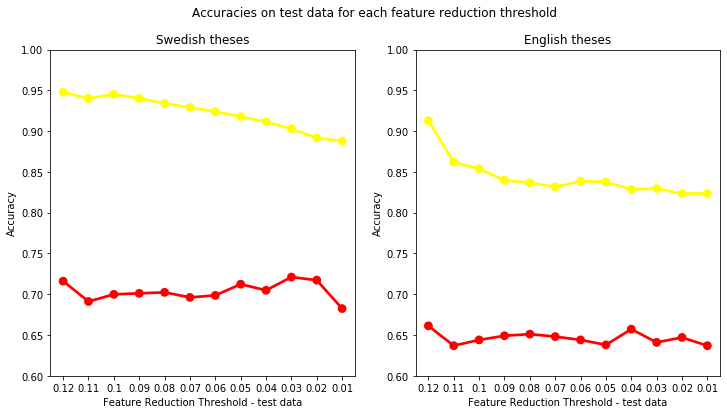

In [43]:

accuracies_test_gender  = [accuracy_score([gen for (top,gen) in y_test], log_model_topic_reduced[i].predict(inputs_topic_reduced_test[i])) for i in range(len(thresholds))]

accuracies_test_topic   = [accuracy_score([top for (top,gen) in y_test], log_model_topic_reduced_topic[i].predict(inputs_topic_reduced_test[i])) for i in range(len(thresholds))]

accuracies_test_gender_eng  = [accuracy_score([gen for (top,gen) in y_test_eng], log_model_topic_reduced_eng[i].predict(inputs_topic_reduced_test_eng[i])) for i in range(len(thresholds))]

accuracies_test_topic_eng  = [accuracy_score([top for (top,gen) in y_test_eng], log_model_topic_reduced_topic_eng[i].predict(inputs_topic_reduced_test_eng[i])) for i in range(len(thresholds))]


fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,6))
fig.suptitle('Accuracies on test data for each feature reduction threshold')
axes[0].set_title('Swedish theses')
axes[1].set_title('English theses')

axes[0].set_ylim(0.6,1.0)
axes[1].set_ylim(0.6,1.0)

gender_test = {"Feature Reduction Threshold - test data": thresholds,
              "Accuracy":accuracies_test_gender,
             };

topic_test = {"Feature Reduction Threshold - test data":thresholds, 
              "Accuracy":accuracies_test_topic,
             };

gender_test_eng = {"Feature Reduction Threshold - test data": thresholds,
              "Accuracy":accuracies_test_gender_eng,
             };

topic_test_eng = {"Feature Reduction Threshold - test data":thresholds, 
              "Accuracy":accuracies_test_topic_eng,
             };


df_gen_test       = pd.DataFrame(gender_test);
df_topic_test     = pd.DataFrame(topic_test);
df_gen_test_eng   = pd.DataFrame(gender_test_eng);
df_topic_test_eng = pd.DataFrame(topic_test_eng);



sns.pointplot(x="Feature Reduction Threshold - test data", 
                   ax = axes[0],
                   y="Accuracy", 
              
                   data=df_gen_test,
                   order = thresholds,
                   color='red');


sns.pointplot(x="Feature Reduction Threshold - test data", 
                  ax = axes[0],
                   y="Accuracy", 
            
                   data=df_topic_test,
                   order=thresholds,
                   color='yellow');


sns.pointplot(x="Feature Reduction Threshold - test data", 
                   ax = axes[1],
                   y="Accuracy", 
              ylim=(0.6,1.0),
                   data=df_gen_test_eng,
                   order = thresholds,
                   color='red');


sns.pointplot(x="Feature Reduction Threshold - test data", 
                  ax = axes[1],
                   y="Accuracy",
                  ylim=(0.6,1.0),
                   data=df_topic_test_eng,
                   order=thresholds,
                   color='yellow');

plt.show();



#### Drop the features most relevant to topic (with a topic coefficient > 0.01) and plot the first two principal components of the training data ####

In [44]:
# Number of features still used at threshold 0.01
print((inputs_topic_reduced_train[12]).shape[1])
print((inputs_topic_reduced_train_eng[12]).shape[1])

390
185


In [45]:
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(((inputs_topic_reduced_train[0]).todense()))

pca_reduced = PCA(n_components=2)
pca_transformed_reduced = pca.fit_transform(((inputs_topic_reduced_train[12]).todense()))

In [46]:
pca_eng = PCA(n_components=2)
pca_transformed_eng = pca_eng.fit_transform((inputs_topic_reduced_train_eng[0]).todense())

pca_eng_reduced = PCA(n_components=2)
pca_transformed_reduced_eng = pca_eng.fit_transform((inputs_topic_reduced_train_eng[12]).todense())

#### Plot PCA components of topic reduced data - there is still a clear pattern for topics ####

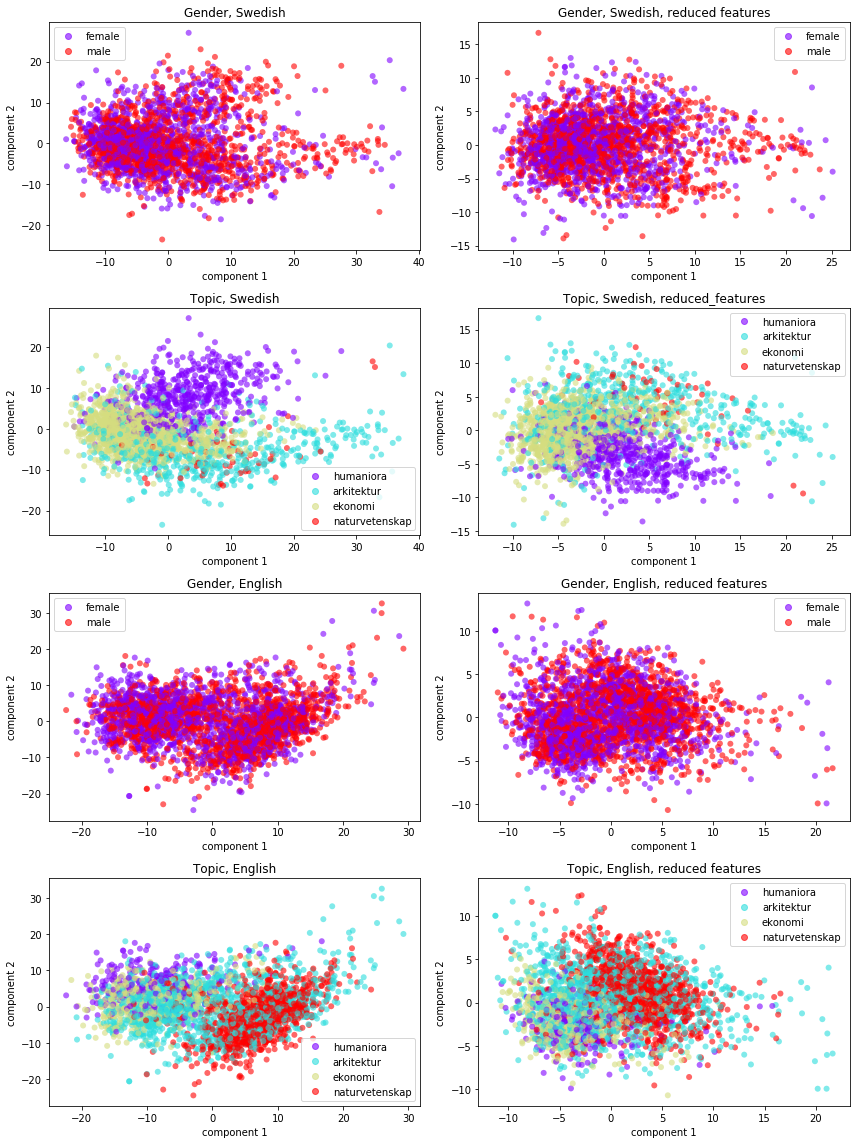

In [47]:


def plot_pca(title,x,y,labels,labelnames) : 

    plt.title(title)
    scatter = plt.scatter(x,y,
        c = labels, edgecolor='none', alpha=0.6,
        cmap = plt.cm.get_cmap('rainbow', len(labels)))
    plt.xlabel("component 1")
    plt.ylabel("component 2")
    plt.legend(handles=scatter.legend_elements()[0], labels=labelnames)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,16))
plt.subplot(4, 2, 1)
plot_pca('Gender, Swedish',pca_transformed[:, 0],pca_transformed[:, 1],labels_gen_train,["female","male"])

plt.subplot(4, 2, 2)
plot_pca('Gender, Swedish, reduced features',pca_transformed_reduced[:, 0],pca_transformed_reduced[:, 1],labels_gen_train,["female","male"])

plt.subplot(4, 2, 3)
plot_pca('Topic, Swedish',pca_transformed[:, 0],pca_transformed[:, 1],labels_topic_train,["humaniora","arkitektur","ekonomi","naturvetenskap"])

plt.subplot(4, 2, 4)
plot_pca('Topic, Swedish, reduced_features',pca_transformed_reduced[:, 0],pca_transformed_reduced[:, 1],labels_topic_train,["humaniora","arkitektur","ekonomi","naturvetenskap"])


plt.subplot(4, 2, 5)
plot_pca('Gender, English',pca_transformed_eng[:, 0],pca_transformed_eng[:, 1],labels_gen_train_eng,["female","male"])

plt.subplot(4, 2, 6)
plot_pca('Gender, English, reduced features',pca_transformed_reduced_eng[:, 0],pca_transformed_reduced_eng[:, 1],labels_gen_train_eng,["female","male"])

plt.subplot(4, 2, 7)
plot_pca('Topic, English',pca_transformed_eng[:, 0],pca_transformed_eng[:, 1],labels_topic_train_eng,["humaniora","arkitektur","ekonomi","naturvetenskap"])

plt.subplot(4, 2, 8)
plot_pca('Topic, English, reduced features',pca_transformed_reduced_eng[:, 0],pca_transformed_reduced_eng[:, 1],labels_topic_train_eng,["humaniora","arkitektur","ekonomi","naturvetenskap"])


plt.tight_layout()


#### Get the smallest difference of the coefficients for each topic ####


In [48]:

def min_diffs(cs) :
    cs_pos = [c for c in cs if c > 0]
    difflist = [abs(c1 - c2) for c1 in cs for c2 in cs if c1 != c2]
    if difflist == [] : difflist = [0]
    min_diff = min(difflist)
    return min_diff




#### Iteratively remove features whose difference between any of the coefficients for the topics is greater than the absolute value of the coefficient for gender. ####

In [49]:

mods = [logreg() for i in range(30)]
mods_gen = [logreg() for i in range(30)]
newinputs = freqs


accuracies = []
accuracies_gen = []

for i in range(30) :
    
    
    print(len(newinputs[0]))

    inputs_topic_reduced_train = [newinputs[i] for i in X_train_indices]
    inputs_topic_reduced_test  = [newinputs[i] for i in X_test_indices]  

    mods[i].fit(inputs_topic_reduced_train,labels_topic_train)
    mods_gen[i].fit(inputs_topic_reduced_train,labels_gen_train)
    
    acc = accuracy_score(labels_topic_test, mods[i].predict(inputs_topic_reduced_test))
    print(acc)
    accuracies.append(acc)
    acc_gen = accuracy_score(labels_gen_test, mods_gen[i].predict(inputs_topic_reduced_test))
    print(acc_gen)
    accuracies_gen.append(acc_gen)
    
    coefs_topic      = mods[i].coef_
    coefs_humaniora  = coefs_topic[0]
    coefs_arkitektur = coefs_topic[1]
    coefs_ekonomi    = coefs_topic[2]
    coefs_natur      = coefs_topic[3]
    
    # max_coefs_topic = [max([coefs_humaniora[i],coefs_arkitektur[i],coefs_ekonomi[i],coefs_natur[i]]) for i in range(len(coefs_topic[0]))]
    max_diff_coefs_topic = [min_diffs([coefs_humaniora[i],coefs_arkitektur[i],coefs_ekonomi[i],coefs_natur[i]]) for i in range(len(coefs_topic[0]))]
    coefs_gender = mods_gen[i].coef_[0]
    
    
    keep_coefficients = [((abs(gen_coef) - top_coef) > 0) for top_coef,gen_coef in zip(max_diff_coefs_topic,coefs_gender)]
  #  print(len(keep_coefficients))
  #  print(keep_coefficients)
    newinputs_ = [[inp[i] for i in range(len(inp)) if keep_coefficients[i]] for inp in newinputs] 
           
   
    if (len(newinputs_[0]) == len(newinputs[0])) :
        # No change from previous iteration - stop
        break
    newinputs = newinputs_


1006


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.9539227895392279
0.7148194271481942
677


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.9389788293897883
0.7073474470734745
529


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.9290161892901619
0.6998754669987547
402


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.9140722291407223
0.7048567870485679
289


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.9140722291407223
0.709838107098381
186


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.9066002490660025
0.6986301369863014
119


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8667496886674969
0.6998754669987547
80


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8393524283935243
0.7061021170610212
54


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7708592777085927
0.6774595267745953
42


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7285180572851806
0.6488169364881694
34


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7135740971357409
0.6587795765877957
29


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.684931506849315
0.660024906600249
28


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6787048567870486
0.6587795765877957
27


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6874221668742216
0.6575342465753424


#### Same as above, for English #### 

In [51]:

mods_eng = [logreg() for i in range(30)]
mods_gen_eng = [logreg() for i in range(30)]
newinputs_eng = freqs_eng


accuracies_eng = []
accuracies_gen_eng = []

for i in range(30) :
    
    
    print(len(newinputs_eng[0]))

    inputs_topic_reduced_train_eng = [newinputs_eng[i] for i in X_train_indices_eng]
    inputs_topic_reduced_test_eng  = [newinputs_eng[i] for i in X_test_indices_eng]  

    mods_eng[i].fit(inputs_topic_reduced_train_eng,labels_topic_train_eng)
    mods_gen_eng[i].fit(inputs_topic_reduced_train_eng,labels_gen_train_eng)
    
    acc = accuracy_score(labels_topic_test_eng, mods_eng[i].predict(inputs_topic_reduced_test_eng))
    print(acc)
    accuracies_eng.append(acc)
    acc_gen = accuracy_score(labels_gen_test_eng, mods_gen_eng[i].predict(inputs_topic_reduced_test_eng))
    print(acc_gen)
    accuracies_gen_eng.append(acc_gen)
    
    coefs_topic      = mods_eng[i].coef_
    coefs_humaniora  = coefs_topic[0]
    coefs_arkitektur = coefs_topic[1]
    coefs_ekonomi    = coefs_topic[2]
    coefs_natur      = coefs_topic[3]
    
    max_diff_coefs_topic = [min_diffs([coefs_humaniora[i],coefs_arkitektur[i],coefs_ekonomi[i],coefs_natur[i]]) for i in range(len(coefs_topic[0]))]
    coefs_gender = mods_gen_eng[i].coef_[0]
    
    
    keep_coefficients = [((abs(gen_coef) - top_coef) > 0) for top_coef,gen_coef in zip(max_diff_coefs_topic,coefs_gender)]

    newinputs_eng_ = [[inp[i] for i in range(len(inp)) if keep_coefficients[i]] for inp in newinputs_eng] 
           
   
    if (len(newinputs_eng_[0]) == len(newinputs_eng[0])) :
        # No change from previous iteration - stop
        break
    newinputs_eng = newinputs_eng_


937


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.920892494929006
0.6592292089249493
566


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8995943204868154
0.6582150101419878
372


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8630831643002028
0.6460446247464503
249


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.8275862068965517
0.6531440162271805
163


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7971602434077079
0.6511156186612576
103


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7525354969574036
0.6277890466531441
68


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.7038539553752535
0.6206896551724138
45


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6247464503042597
0.603448275862069
37


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.6085192697768763
0.6064908722109533
27


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.5740365111561866
0.6064908722109533
23


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.565922920892495
0.6115618661257607
19


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.48580121703853957
0.5851926977687627
16


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.4716024340770791
0.5993914807302231
14


/opt/anaconda3/envs/idp/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.4685598377281947
0.5973630831643002


In [85]:


#(inputs_topic_reduced_train_eng[0])
#for i in range(len(new_inputs_eng[0])) :
#    print(len(new_inputs_eng[0][i]))

In [94]:
#len(freqs_eng)
#len(newinputs_eng_[0])
#len(newinputs_eng[0])

len(inputs_topic_reduced_train_eng[0])

14

#### When reducing the features, the accuracy drops faster for topic than for gender, but still stays above the baseline ####

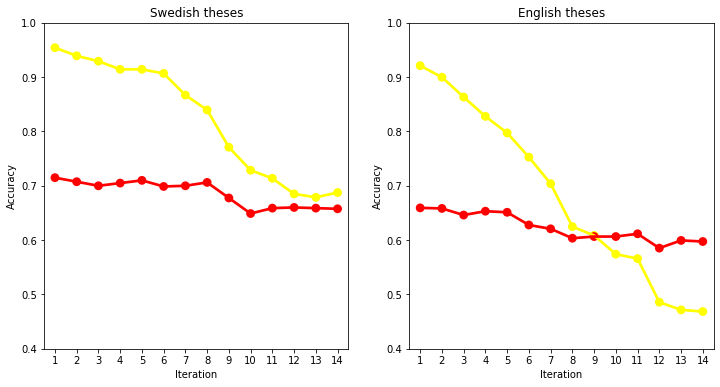

In [88]:

iterations = [i+1 for i in range(len(accuracies_gen)) ] # [1,2,3,4,5,6,7,8,9,10,11]

iterations_eng = [i+1 for i in range(len(accuracies_gen_eng))] # [1,2,3,4,5,6,7,8,9,10,11,12,13,14]

accuracies_test_gender  = accuracies_gen 

accuracies_test_topic   = accuracies 

gender_test_eng = {"Iteration": iterations_eng,
              "Accuracy":accuracies_gen_eng,
             };

topic_test_eng = {"Iteration":iterations_eng, 
              "Accuracy":accuracies_eng,
             };


gender_test = {"Iteration": iterations,
              "Accuracy":accuracies_test_gender,
             };

topic_test = {"Iteration":iterations, 
              "Accuracy":accuracies_test_topic,
             };




df_gen_test   = pd.DataFrame(gender_test);

df_topic_test = pd.DataFrame(topic_test);

df_gen_test_eng   = pd.DataFrame(gender_test_eng);

df_topic_test_eng = pd.DataFrame(topic_test_eng);


fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12,6))
#fig.suptitle('Accuracies on test data for each feature reduction threshold')
axes[0].set_title('Swedish theses')
axes[1].set_title('English theses')


axes[0].set_ylim(0.4,1.0)
axes[1].set_ylim(0.4,1.0)

sns.pointplot(x="Iteration", 
                   y="Accuracy", 
                   ax = axes[0],
                   data=df_gen_test,
                   order = iterations,
                   color='red');


sns.pointplot(x="Iteration", 
                   y="Accuracy", 
                   ax = axes[0],
                   data=df_topic_test,
                   order=iterations,
                   color='yellow');

sns.pointplot(x="Iteration", 
                   y="Accuracy", 
                   ax = axes[1],
                   data=df_topic_test_eng,
                   order = iterations_eng,
                   color='yellow');

sns.pointplot(x="Iteration", 
                   y="Accuracy", 
                   ax = axes[1],
                   data=df_gen_test_eng,
                   order = iterations_eng,
                   color='red');


plt.show();



#### Plot the pca components of the English and Swedish training data with the reduced features from the final iteration. We can still see a pattern for topics, especially for the Swedish data ####

In [95]:
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(inputs_topic_reduced_train_eng)

pca_reduced = PCA(n_components=2)
pca_transformed_reduced = pca_reduced.fit_transform(inputs_topic_reduced_train)



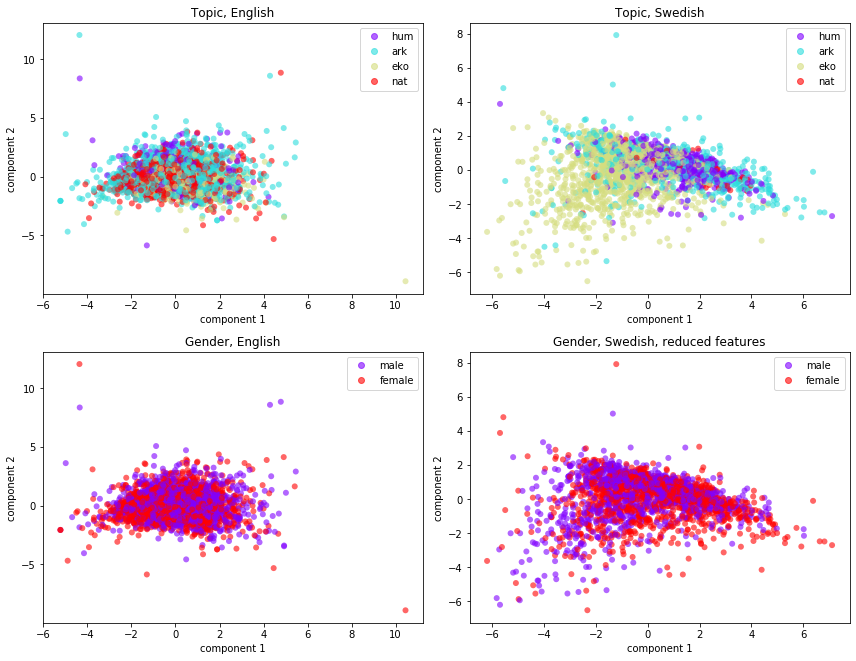

In [97]:
fig = plt.figure(figsize=(12,18))
plt.subplot(4, 2, 1)
plot_pca('Topic, English',pca_transformed[:, 0],pca_transformed[:, 1],labels_topic_train_eng,["hum","ark","eko","nat"])

plt.subplot(4, 2, 2)
plot_pca('Topic, Swedish',pca_transformed_reduced[:, 0],pca_transformed_reduced[:, 1],labels_topic_train,["hum","ark","eko","nat"])
plt.subplot(4, 2, 3)
plot_pca('Gender, English',pca_transformed[:, 0],pca_transformed[:, 1],labels_gen_train_eng,["male","female"])

plt.subplot(4, 2, 4)
plot_pca('Gender, Swedish, reduced features',pca_transformed_reduced[:, 0],pca_transformed_reduced[:, 1],labels_gen_train,["male","female"])

plt.tight_layout()

In [98]:
(inputs_topic_reduced_train_eng[0])

[1.7525405292319272,
 -0.7959160271771006,
 -0.3409010145091771,
 4.53867831245951,
 -1.8916724078554603,
 -1.6918074081391976,
 -1.2325187993257107,
 -1.555829866089969,
 -1.0553075162800303,
 -0.4360331063194681,
 -1.0298597433309646,
 -0.4707076997505672,
 -0.03837688244726257,
 -0.03008140082486578]

In [108]:
# Get the names of the features still used...

# indices 
freqs_train = [freqs_eng[i] for i in X_train_indices_eng]
kept_indices = [ i for i  in range(len(freqs_train[0])) if freqs_train[0][i] in inputs_topic_reduced_train_eng[0] ]

In [109]:
[freqs_features_eng[i] for i in kept_indices]

["('JJ', 'NN')",
 "('NNS', 'VBP')",
 "('CD', 'CD', 'CD')",
 "('NN', 'CC', 'DT')",
 "('VBZ', 'DT', 'JJ')",
 "('RB', 'DT', 'NN')",
 "(',', 'NN', 'CC')",
 "('NNS', 'VBP', 'RB')",
 "(',', 'CC', 'DT')",
 'also',
 'therefore',
 'me',
 'suchlike',
 'ourself']